<a href="https://colab.research.google.com/github/AmazingK2k3/Over_Squashing_GNNs/blob/main/MUTAG_GraphSAGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.5 MB/s eta 0:00:00


In [3]:
import networkx as nx
import pandas as pd
import torch
import numpy as np
import os
import random
import sklearn
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout

from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import global_mean_pool, global_add_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight


import matplotlib.pyplot as plt
from torch_geometric.utils import to_dense_adj
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.nn import global_max_pool
from torch.nn import Sequential, Linear, ReLU


from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader



## Loading MUTAG Dataset



*  1 indicates mutagenicity (causing genetic mutation)
*   0 indicates no mutagenicity




## Parameters of the PyG data object
:
x (torch.Tensor, optional) – Node feature matrix with shape [num_nodes, num_node_features]. (default: None)

edge_index (LongTensor, optional) – Graph connectivity in COO format with shape [2, num_edges]. (default: None)

edge_attr (torch.Tensor, optional) – Edge feature matrix with shape [num_edges, num_edge_features]. (default: None)

y (torch.Tensor, optional) – Graph-level or node-level ground-truth labels with arbitrary shape. (default: None)



In [4]:
from torch_geometric.datasets import TUDataset

mutag = TUDataset(root = 'Over_Squashing_GNNs/data/Mutag', name = 'MUTAG')
print("len:", len(mutag))
print("num_classes:", mutag.num_classes)
print("num_node_features:", mutag.num_node_features)

len: 188
num_classes: 2
num_node_features: 7


Processing...
Done!


In [5]:
example = mutag[0]
y = example.x.shape  #([number of nodes, num_node_features])
print(y[0], y[1])

17 7


In [6]:
for i in range(len(mutag)):
  x = mutag[i]
  if x.y.size(0) == 0:
    print(x)
# to check if all labels exist

In [7]:
mutag?

In [8]:
for i in range(100):
  dx = mutag[i]
  #print(dx.edge_index.shape)
  print(dx.x.shape)


torch.Size([17, 7])
torch.Size([13, 7])
torch.Size([13, 7])
torch.Size([19, 7])
torch.Size([11, 7])
torch.Size([28, 7])
torch.Size([16, 7])
torch.Size([20, 7])
torch.Size([12, 7])
torch.Size([17, 7])
torch.Size([17, 7])
torch.Size([20, 7])
torch.Size([22, 7])
torch.Size([13, 7])
torch.Size([19, 7])
torch.Size([22, 7])
torch.Size([11, 7])
torch.Size([17, 7])
torch.Size([13, 7])
torch.Size([18, 7])
torch.Size([18, 7])
torch.Size([17, 7])
torch.Size([23, 7])
torch.Size([27, 7])
torch.Size([17, 7])
torch.Size([13, 7])
torch.Size([23, 7])
torch.Size([17, 7])
torch.Size([23, 7])
torch.Size([23, 7])
torch.Size([22, 7])
torch.Size([24, 7])
torch.Size([23, 7])
torch.Size([13, 7])
torch.Size([17, 7])
torch.Size([14, 7])
torch.Size([17, 7])
torch.Size([15, 7])
torch.Size([15, 7])
torch.Size([13, 7])
torch.Size([17, 7])
torch.Size([13, 7])
torch.Size([19, 7])
torch.Size([17, 7])
torch.Size([12, 7])
torch.Size([23, 7])
torch.Size([22, 7])
torch.Size([17, 7])
torch.Size([20, 7])
torch.Size([16, 7])


In [9]:
mutag[18]

Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])

## Visualization of Bridges

Graph 1
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


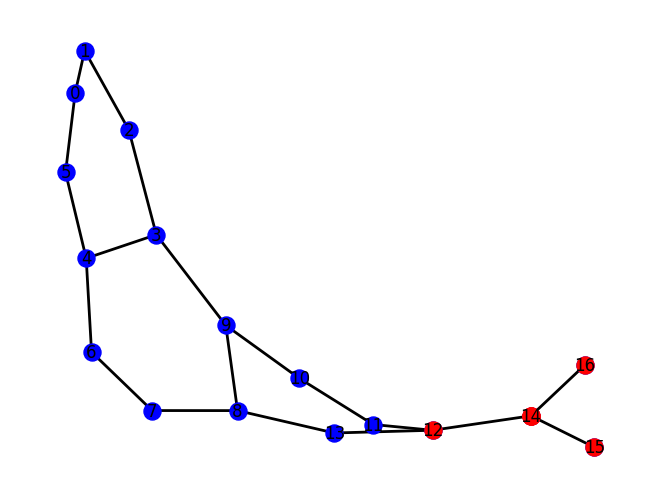

Graph 2
Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])


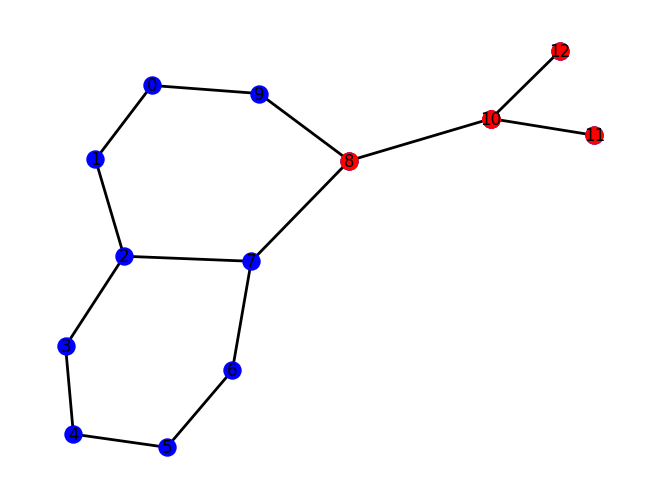

Graph 3
Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])


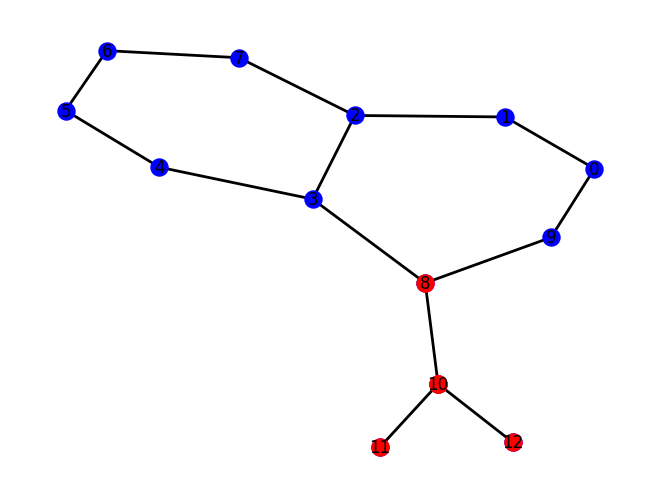

Graph 4
Data(edge_index=[2, 44], x=[19, 7], edge_attr=[44, 4], y=[1])


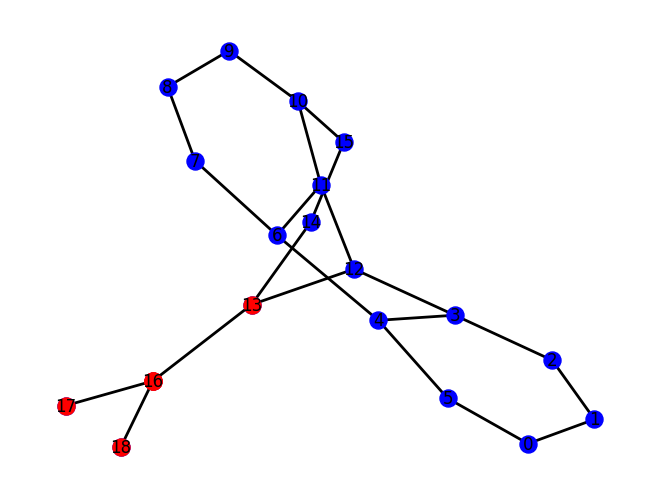

Graph 5
Data(edge_index=[2, 22], x=[11, 7], edge_attr=[22, 4], y=[1])


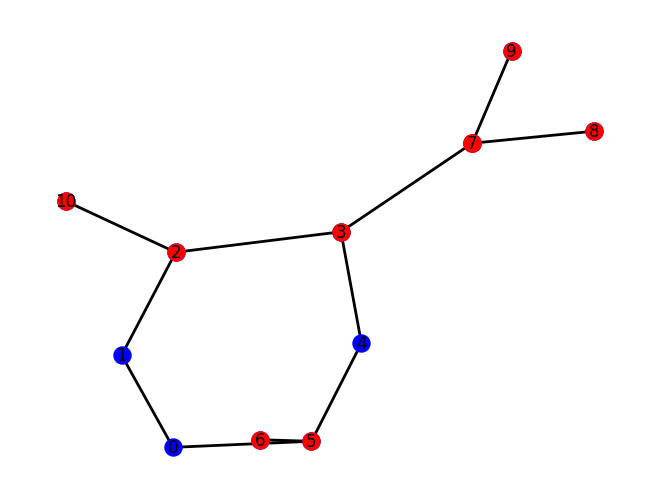

Graph 6
Data(edge_index=[2, 62], x=[28, 7], edge_attr=[62, 4], y=[1])


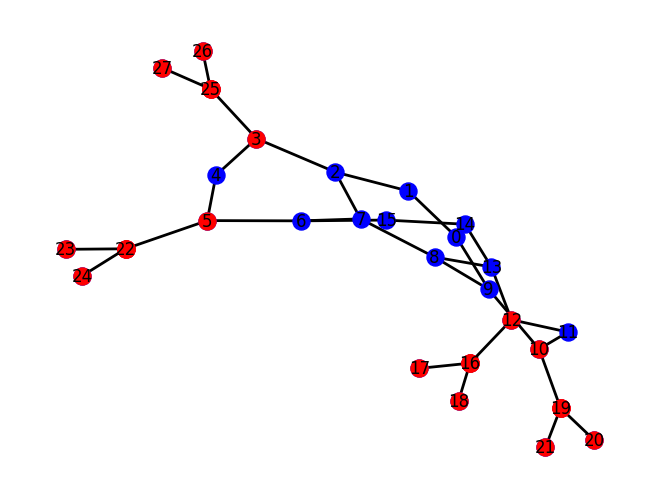

Graph 7
Data(edge_index=[2, 34], x=[16, 7], edge_attr=[34, 4], y=[1])


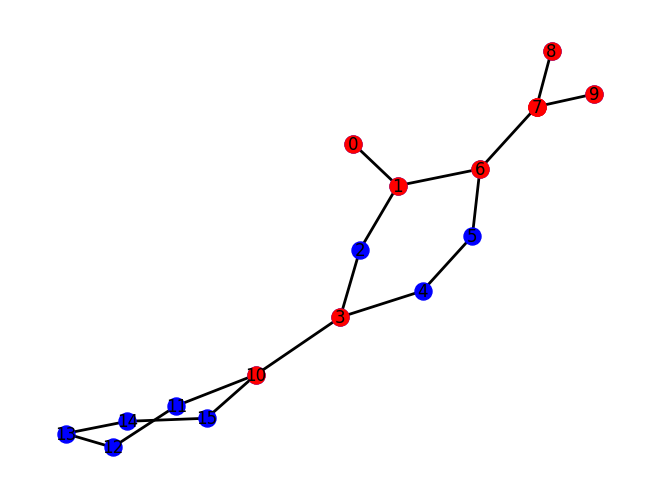

Graph 8
Data(edge_index=[2, 44], x=[20, 7], edge_attr=[44, 4], y=[1])


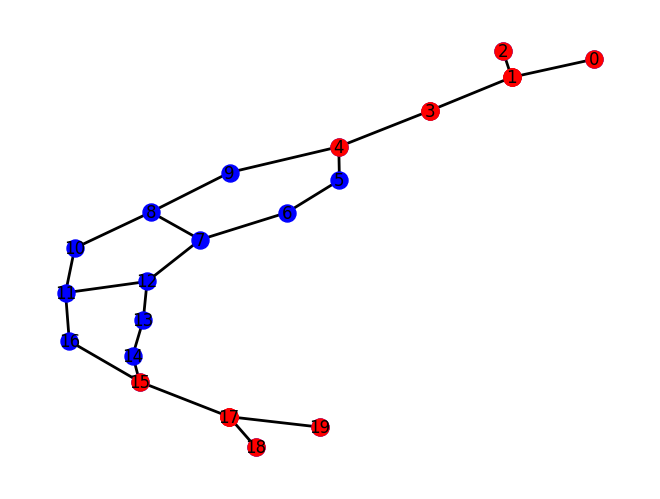

Graph 9
Data(edge_index=[2, 26], x=[12, 7], edge_attr=[26, 4], y=[1])


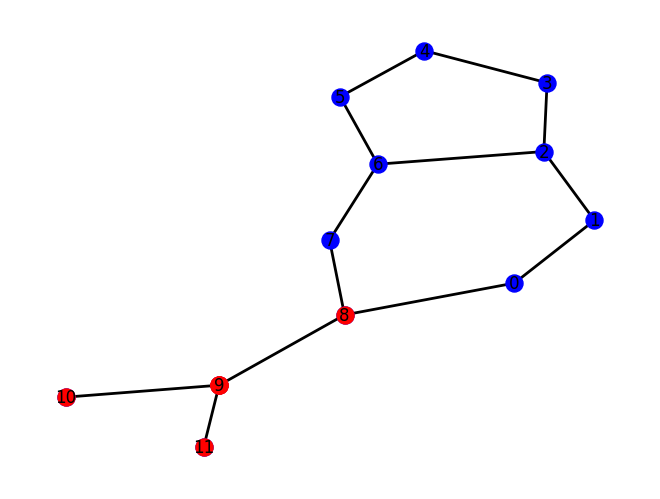

Graph 10
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


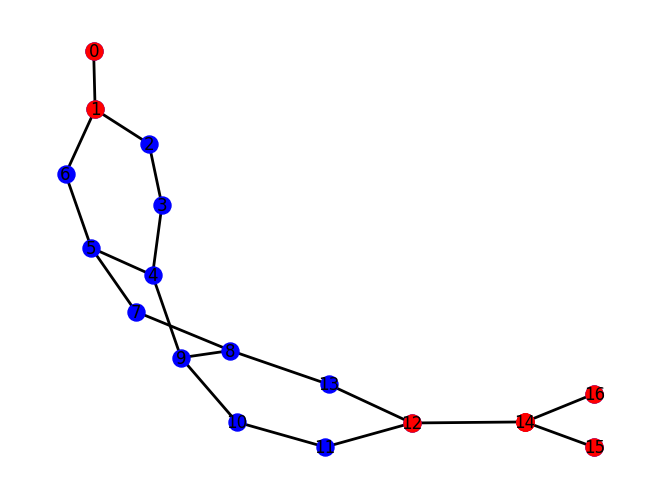

In [10]:
for i in range(10):
  data = mutag[i]
  G = to_networkx(data,to_undirected = True)
  pos = nx.spring_layout(G)
  nx.draw(G, pos, node_color = 'blue', edge_color = 'black',
          node_size = 150, width = 2, with_labels = True)
  bridges = nx.bridges(G)
  print(f"Graph {i+1}")
  for bridge in bridges:
    nx.draw_networkx_nodes(G, pos, nodelist = bridge, node_color = 'red', node_size = 150)
  print(data)
  plt.show()

Graph 1
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


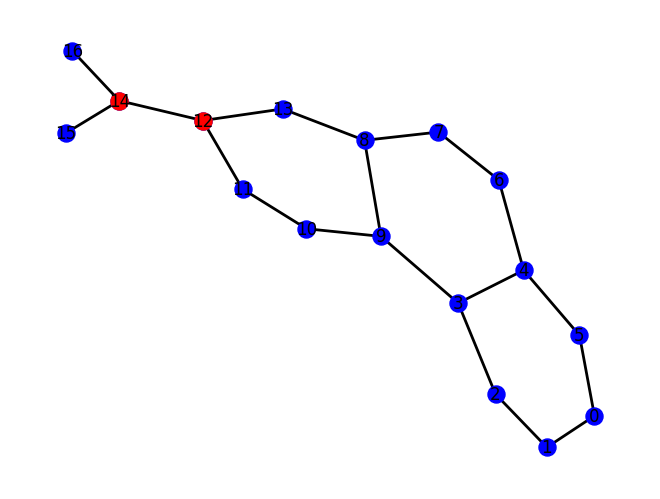

Graph 2
Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])


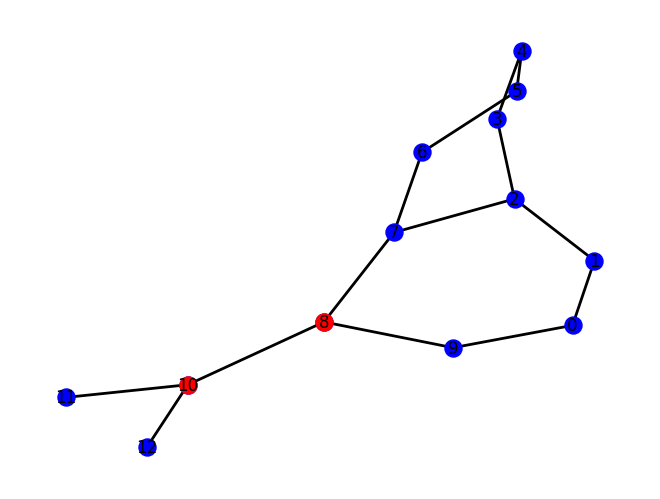

Graph 3
Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])


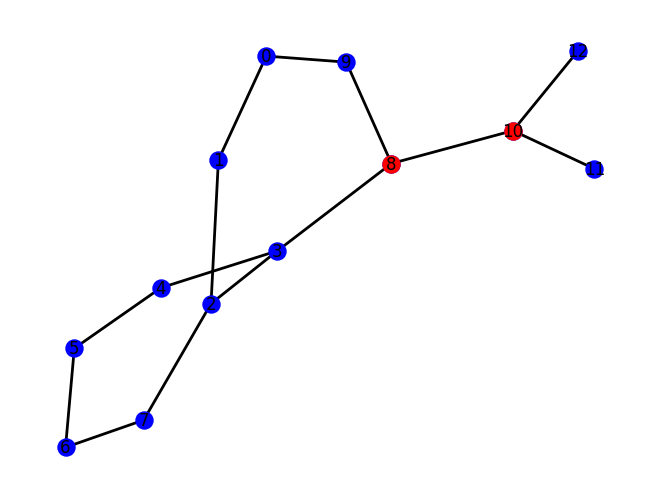

Graph 4
Data(edge_index=[2, 44], x=[19, 7], edge_attr=[44, 4], y=[1])


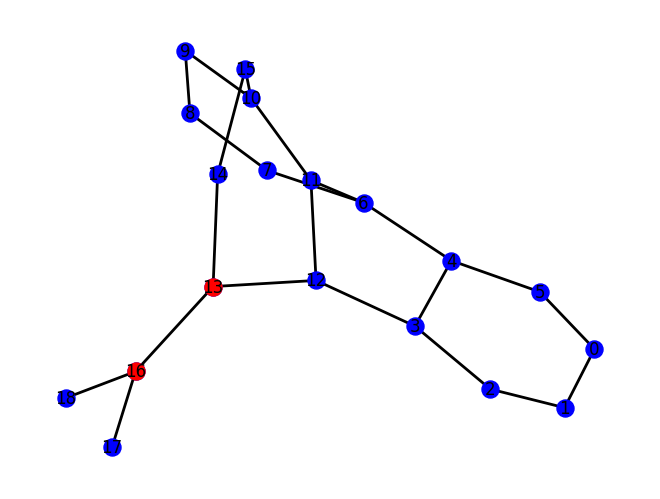

Graph 5
Data(edge_index=[2, 22], x=[11, 7], edge_attr=[22, 4], y=[1])


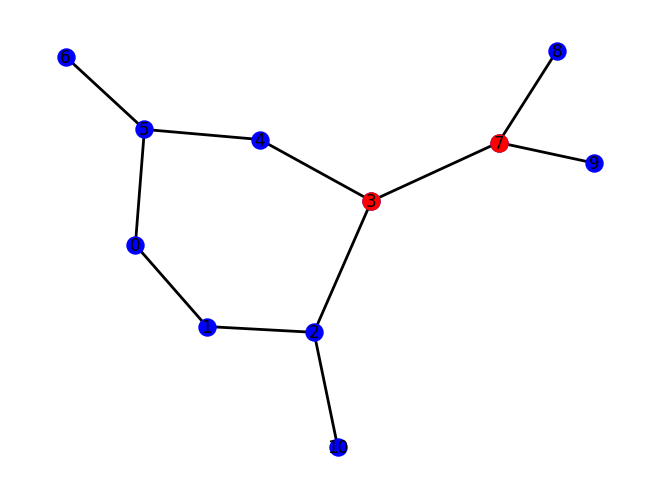

Graph 6
Data(edge_index=[2, 62], x=[28, 7], edge_attr=[62, 4], y=[1])


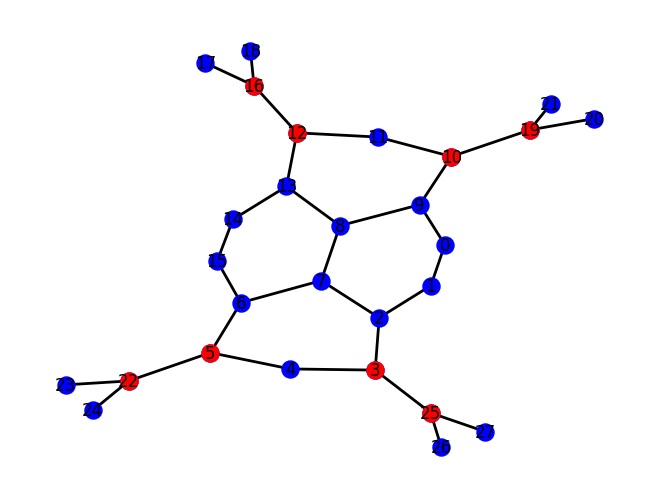

Graph 7
Data(edge_index=[2, 34], x=[16, 7], edge_attr=[34, 4], y=[1])


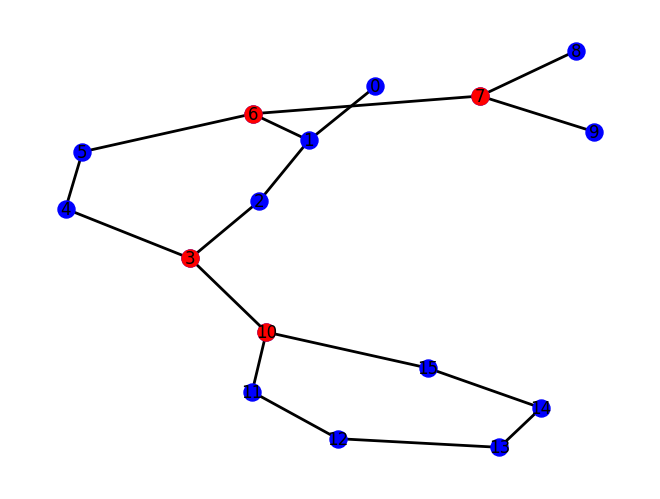

Graph 8
Data(edge_index=[2, 44], x=[20, 7], edge_attr=[44, 4], y=[1])


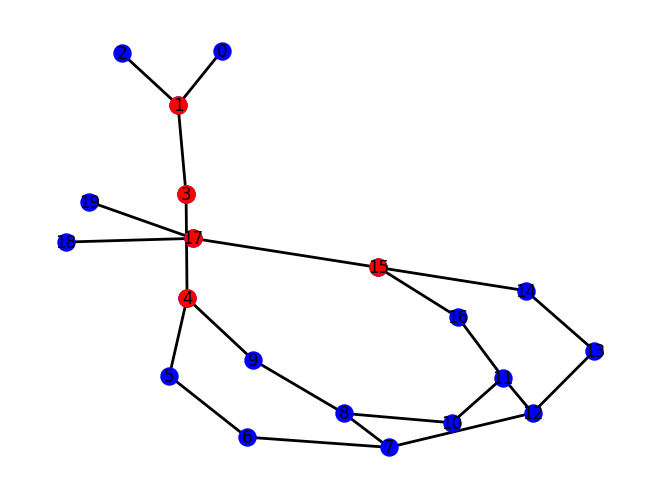

Graph 9
Data(edge_index=[2, 26], x=[12, 7], edge_attr=[26, 4], y=[1])


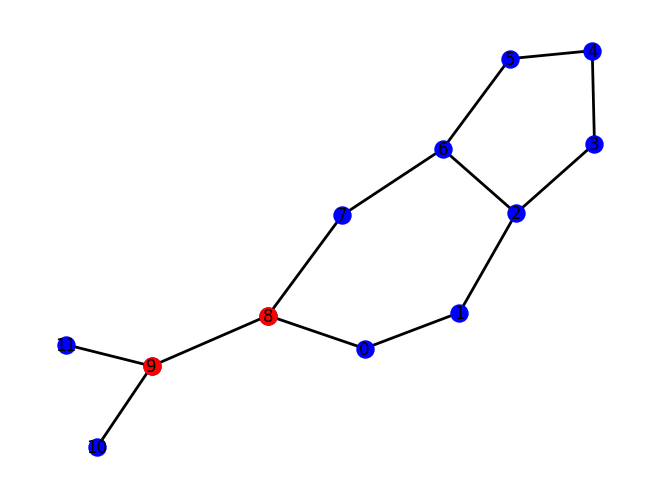

Graph 10
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


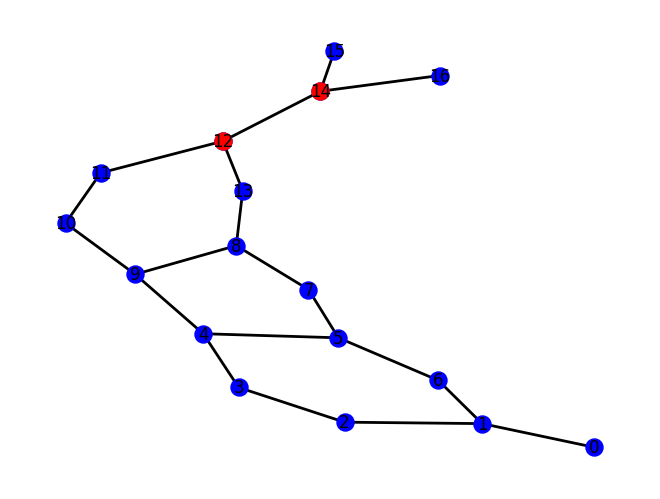

In [11]:
# Considering only Bridges where the neighbours of bridges nodes are connected to more nodes than bridges nodes
for i in range(10):
  data = mutag[i]
  G = to_networkx(data,to_undirected = True)
  pos = nx.spring_layout(G)
  nx.draw(G, pos, node_color = 'blue', edge_color = 'black',
          node_size = 150, width = 2, with_labels = True)
  bridges = nx.bridges(G)
  print(f"Graph {i+1}")
  for bridge in bridges:
    if len(list(G.neighbors(bridge[0]))) > 1 and len(list(G.neighbors(bridge[1]))) > 1:
      nx.draw_networkx_nodes(G, pos, nodelist = bridge, node_color = 'red', node_size = 150)
  print(data)
  plt.show()


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Rewiring:

In [ ]:
def rewire(data):
  G = to_networkx(data, to_undirected = True)
  bridges = list(nx.bridges(G))

  adj_node_dict = {}
  for i in bridges:
    for j in i:
      adj_nodes = list(nx.all_neighbors(G,j))
      adj_node_dict.update({j : adj_nodes})

  keys = set(adj_node_dict.keys())

  for key, values in adj_node_dict.items():
    # Remove any bridge node found in the list
    adj_node_dict[key] = [v for v in values if v not in keys]

  for u, v in bridges:
    neighbors_u = adj_node_dict.get(u,[])
    neighbors_v = adj_node_dict.get(v,[])

  for node_u in neighbors_u:
    for node_v in neighbors_v:
      if not G.has_edge(node_u, node_v): # if the edge does not already exist
        G.add_edge(node_u, node_v) # add the edge

  #Gx.remove_edge(u,v) # removing bridge node

  adj_matrix = nx.adjacency_matrix(G).toarray()
  # function should return the edge_index

  edge_index = torch.tensor(adj_matrix, dtype=torch.long)

  edge_index = edge_index.nonzero().t().contiguous() # (2,num_edges) format and contigous memory.

  return edge_index

In [ ]:
# run rewire for all graphs in MUTAG

### GraphSAGE with normal wiring


In [ ]:
num_node_features = 7
# num_node_features is the number of node features.

# from binascii import a2b_hex

# from torch_geometric.nn import SAGEConv
# import itertools
# edges = list(itertools.permutations(range(18),2))
# full_adj = torch.tensor(edges,dtype = torch.long).t().contiguous().to(device)
class GraphSAGE(torch.nn.Module):
    def __init__(self, dim_h):
        super().__init__()

        self.batch_norm1 = BatchNorm1d(dim_h)
        self.batch_norm2 = BatchNorm1d(dim_h//2)
        self.batch_norm3 = BatchNorm1d(dim_h//4)
        self.sage1 = SAGEConv(num_node_features, dim_h, aggr='mean',
            normalize=True) #7 * 128
        self.sage2 = SAGEConv(dim_h, dim_h//2, aggr='mean',
            normalize=True) #128 * 64
        self.sage3 = SAGEConv(dim_h//2, dim_h//4, aggr='mean',normalize=True) # 64 * 32
        self.lin = Linear((dim_h//4), 1)  # 64 * 1


    def forward(self, x, edge_index, batch):

#(32x64 and 32x1)
        h1 = self.sage1(x, edge_index) # 7 * 128
        h1 = self.batch_norm1(h1)
        h = F.elu(h1) # 128
        h = F.dropout(h, p=0.5, training=self.training) # 128
        h2 = self.sage2(h, edge_index) # 128 * 64
        h2 = self.batch_norm2(h2)
        h = F.elu(h2)
        h = F.dropout(h, p=0.5, training=self.training)
        h3 = self.sage3(h,edge_index) # 64 * 32
        h3 = self.batch_norm3(h3)
        h = F.elu(h3)
        h = global_mean_pool(h, batch) # 32 * 32
       # h = F.dropout(h, p=0.5, training=self.training)
        x = self.lin(h) # 32 * 1
        return torch.sigmoid(x)
        # return F.log_softmax(x, dim=1)



### GraphSAGE with Full Adjacency

In [ ]:

# num_node_features is the number of node features.

# from binascii import a2b_hex
import itertools


class GraphSAGE_FA(torch.nn.Module):
    def __init__(self, dim_h):
        super().__init__()
        self.batch_norm1 = BatchNorm1d(dim_h)
        self.batch_norm2 = BatchNorm1d(dim_h//2)
        self.batch_norm3 = BatchNorm1d(dim_h//4)
        self.sage1 = SAGEConv(num_node_features, dim_h, aggr='mean',
            normalize=True) #7 * 128
        self.sage2 = SAGEConv(dim_h, dim_h//2, aggr='mean',
            normalize=True) #128 * 64
        self.sage3 = SAGEConv(dim_h//2, dim_h//4, aggr='mean',normalize=True) # 64 * 32
        self.lin = Linear((dim_h//4), 1)  # 32 * 1

    def forward(self, x, edge_index, batch):

        h1 = self.sage1(x, edge_index) # 7 * 128
        h1 = self.batch_norm1(h1)
        h = F.elu(h1) # 128
        h = F.dropout(h, p=0.5, training=self.training) # 128
        h2 = self.sage2(h, edge_index) # 128 * 64
        h2 = self.batch_norm2(h2)
        h = F.elu(h2)
        h = F.dropout(h, p=0.5, training=self.training)

        num_nodes = x.size(0)
        full_edges = torch.combinations(torch.arange(num_nodes), r=2).t().contiguous()  # Generate all pairs
        full_edge_index = torch.cat([full_edges, full_edges.flip(0)], dim=1)  # Make it undirected
        full_edge_index = full_edge_index.to(h.device)

        h3 = self.sage3(h,full_edge_index) # 64 * 32
        h3 = self.batch_norm3(h3)
        h = F.elu(h3)
        h = global_mean_pool(h, batch) # 32 * 32
       # h = F.dropout(h, p=0.5, training=self.training)
        x = self.lin(h) # 32 * 1
        return torch.sigmoid(x)
        # return F.log_softmax(x, dim=1)




### GraphSAGE with Locally FA

In [ ]:

# num_node_features is the number of node features.

# from binascii import a2b_hex
import itertools


class GraphSAGE(torch.nn.Module):
    def __init__(self, dim_h):
        super().__init__()
        self.sage1 = SAGEConv(num_node_features, dim_h) #7 * 128
        self.sage2 = SAGEConv(dim_h, dim_h//2) #128 * 64
        self.sage3 = SAGEConv(dim_h//2, dim_h//4) # 64 * 32
        self.lin = Linear((dim_h//2), 1)  # 64 * 1

    def forward(self, x, edge_index, batch):
        num_nodes = x.size(0)
        edges = list(itertools.permutations(range(num_nodes),2))
        full_adj = torch.tensor(edges,dtype = torch.long).t().contiguous().to(device)

        h1 = self.sage1(x, edge_index)
        h = F.elu(h1)
        h = F.dropout(h, p=0.5, training=self.training)
        h2 = self.sage2(h, full_adj)


       # print(h.shape)


        #h = torch.cat((a1,a2), dim = 1)
        h = global_mean_pool(h2, batch)
       # print(h.shape) #32 * 64
       # h = F.dropout(h, p=0.5, training=self.training)
        x = self.lin(h)
        return torch.sigmoid(x)



## Loader Function

In [ ]:
def split_data(data, train_size=0.8, val_size=0.1, random_state=42):
    # Convert to list if not already
    data = list(data)

    # First split: separate training set
    temp_data, test_data = train_test_split(
        data,
        test_size=(1-train_size),
        random_state=random_state,
        shuffle=True,
        stratify=[d.y for d in data]
    )

    # Second split: separate validation from test
    # Calculate relative validation size
    relative_val_size = val_size / (1-train_size)
    train_data, val_data = train_test_split(
        temp_data,
        test_size=relative_val_size,
        random_state=random_state,
        shuffle=True,
        stratify=[d.y for d in temp_data]

    )

    return train_data, val_data, test_data


In [ ]:
from torch_geometric.loader import DataLoader


def loader(data, batch_size):
    # for data in data:
    #     data.sort(sort_by_row=False)



    train_data, val_data, test_data = split_data(data)
    #Below used for sorting the edge_index but not working
    # def sort_edge_index(data_list):
    #     for data in data_list:
    #         data.sort(sort_by_row=False)
    #     return data_list

    # train_data = sort_edge_index(train_data)
    # val_data = sort_edge_index(val_data)
    # test_data = sort_edge_index(test_data)







    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True
    )
    val_loader = DataLoader(
        val_data,
        batch_size=batch_size,
        shuffle=False  # No need to shuffle validation
    )
    test_loader = DataLoader(
        test_data,
        batch_size=1,
        shuffle=False  # No need to shuffle test
    )

    return train_loader, val_loader, test_loader


## Result Functions


In [ ]:

def Roc_curve(labels, preds, model_name):
  fpr, tpr, thresholds = roc_curve(labels, preds)
  plt.figure(figsize = (4,4))
  plt.plot(fpr, tpr)
  plt.title(f"{model_name}")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])


In [ ]:
def save_classification_report_txt(report_str, model_name, file_path):
    with open(file_path, 'w') as f:
        f.write(f"Classification Report for {model_name}:\n")
        f.write(report_str)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

def Confusion_matrix(confmat, model_name):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Not Mutagenic', 'Mutagenic'])
    ax.set_yticklabels(['Not Mutagenic', 'Mutagenic'])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f"{model_name}")
    plt.tight_layout()
    plt.show()

def c_matplot(model, test_loader, j):
    all_labels = []
    all_preds = []
    model_name = type(model).__name__
    #model.eval()
    #with torch.no_grad():
    for data in test_loader:
        data.x = data.x.to(device)
        data.edge_index = data.edge_index.to(device)
        data.batch = data.batch.to(device)
        data.y = data.y.to(device)

        out = model(data.x, data.edge_index, data.batch)
        out = out.squeeze()
        out = (out >= 0.5).int()
        out = out.view(-1).detach().cpu().numpy()
        all_labels.extend(data.y.cpu().numpy())
        all_preds.extend(out)

    clf_rp = classification_report(all_labels, all_preds, zero_division=0)
    save_classification_report_txt(clf_rp, model_name, f'Over_Squashing_GNNs/models/Mutag_results/Clf_reports_mutag_Gs/exp{j}_{model_name}.txt')
    conf = confusion_matrix(y_true=all_labels, y_pred=all_preds)
    roc_curve = Roc_curve(all_labels, all_preds, model_name)
    return Confusion_matrix(conf, model_name), print(clf_rp), roc_curve

### Training Loop -1

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

def train(model, loader, lr, epochs,i):
  # all_labels = []
  # for data in loader:
  #     all_labels.extend(data.y.cpu().numpy())
  # class_weights = compute_class_weight('balanced', classes=[0, 1], y=all_labels)
  # weights = torch.tensor(class_weights, dtype=torch.float).to(device)


  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=0.01)
  epochs = epochs
  model.train()

  train_accuracies = []
  val_accuracies = []
  best_val_acc = 0
  best_model_state = None
  for epoch in range(epochs+1):
    total_loss = 0
    acc = 0
    val_loss = 0
    val_acc = 0

    for data in loader:
      data.x = data.x.to(device)
      data.edge_index = data.edge_index.to(device)
      data.y = data.y.to(device).float()
      data.batch = data.batch.to(device)
      #data.y = data.y.view(-1,1)

      optimizer.zero_grad()
      out = model(data.x, data.edge_index, data.batch)
      out = out.view(-1)

      #print("Before view", out)
      loss = criterion(out, data.y)
      total_loss += loss/ len(loader)
      acc += accuracy(out, data.y)/len(loader)
      loss.backward()
      optimizer.step()

    val_loss, val_acc = test(model, val_loader)
    val_acc = round(val_acc,2)
    #print("val_acc",val_acc)
    val_accuracies.append(val_acc)

    #print(len(train_accuracies),len(val_accuracies))
    if val_acc > best_val_acc:
      best_val_acc = val_acc
      best_train_acc = acc
      best_epoch = epoch
      best_model_state = model.state_dict()

   # print("best_val_acc",best_val_acc)
    train_accuracies.append(round(acc*100,2))
   # total_loss /= len(loader)
   # acc /= len(loader)


    if(epoch % 5 == 0):
      print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} | Train Acc: {acc*100:>.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc:.2f}%')
    #print(len(val_accuracies), len(train_accuracies))


  model_name = type(model).__name__

  torch.save(best_model_state, f'Over_Squashing_GNNs/models/Mutag_results/best_models/exp{i}_{model_name}.pth')
  model.load_state_dict(best_model_state)

  plt.figure(figsize=(8, 5))
  plt.plot(range(epochs + 1), train_accuracies, label='Training Accuracy')
  plt.plot(range(epochs + 1), val_accuracies, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title(f'Training vs. Validation Accuracy of {model_name}')
  plt.show()


  #return model, best_val_acc, best_train_acc, best_epoch
  return model, round(best_train_acc * 100, 2), round(best_val_acc, 2), best_epoch
@torch.no_grad()
def test(model, loader):
  criterion = torch.nn.BCELoss()
  #model.eval()
  loss = 0
  acc = 0

  for data in loader:
    data.x = data.x.to(device)
    data.edge_index = data.edge_index.to(device)
    data.y = data.y.to(device).float()
    data.batch = data.batch.to(device)


    out = model(data.x, data.edge_index, data.batch)
    #print("Output shape:", out.shape)
    #print("Target shape:", data.y.shape)

    out = out.view(-1)

    loss += criterion(out, data.y.float())/len(loader)
    acc  += accuracy(out, data.y)/len(loader)

  return loss, round(acc *100, 2)



def accuracy(pred_y, y):
  #print("Before Squeeze", pred_y)
  pred = pred_y.squeeze()
  #print("After Squeeze", pred)
  pred = (pred >= 0.5).float()
  #print("After thresholding", pred)
  return (pred == y).sum().item()/len(y)



# Logs:
# the validation accuracy has been pushed to the epoch for loop, have to run the models again and check how the metrics are changing.
# Check if the best model is the one that is being returned.
# Perform all three experiments with the learning rate set to 0.01


Epoch   0 | Train Loss: 0.73 | Train Acc: 25.42% | Val Loss: 0.71 | Val Acc: 44.44%
Epoch   5 | Train Loss: 0.67 | Train Acc: 57.29% | Val Loss: 0.66 | Val Acc: 56.94%
Epoch  10 | Train Loss: 0.66 | Train Acc: 53.12% | Val Loss: 0.66 | Val Acc: 64.58%
Epoch  15 | Train Loss: 0.60 | Train Acc: 74.58% | Val Loss: 0.65 | Val Acc: 66.67%


Epoch  20 | Train Loss: 0.64 | Train Acc: 72.29% | Val Loss: 0.65 | Val Acc: 69.79%
Epoch  25 | Train Loss: 0.63 | Train Acc: 71.25% | Val Loss: 0.63 | Val Acc: 72.92%
Epoch  30 | Train Loss: 0.59 | Train Acc: 75.62% | Val Loss: 0.63 | Val Acc: 69.79%
Epoch  35 | Train Loss: 0.58 | Train Acc: 72.50% | Val Loss: 0.62 | Val Acc: 71.88%
Epoch  40 | Train Loss: 0.59 | Train Acc: 73.54% | Val Loss: 0.62 | Val Acc: 72.92%
Epoch  45 | Train Loss: 0.57 | Train Acc: 72.50% | Val Loss: 0.61 | Val Acc: 70.83%
Epoch  50 | Train Loss: 0.57 | Train Acc: 78.75% | Val Loss: 0.61 | Val Acc: 72.92%
Epoch  55 | Train Loss: 0.56 | Train Acc: 76.88% | Val Loss: 0.61 | Val Acc: 70.83%
Epoch  60 | Train Loss: 0.60 | Train Acc: 73.33% | Val Loss: 0.60 | Val Acc: 71.88%
Epoch  65 | Train Loss: 0.54 | Train Acc: 76.88% | Val Loss: 0.60 | Val Acc: 70.83%
Epoch  70 | Train Loss: 0.55 | Train Acc: 78.96% | Val Loss: 0.60 | Val Acc: 72.92%
Epoch  75 | Train Loss: 0.58 | Train Acc: 80.00% | Val Loss: 0.60 | Val Acc:

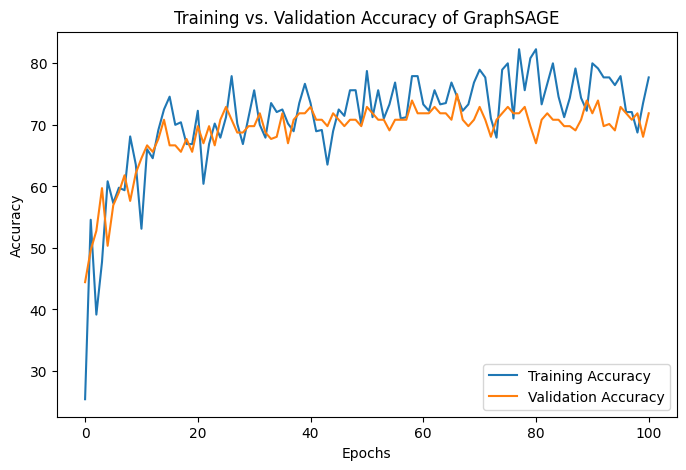

Test Loss: 0.6766180992126465 | Test Acc: 65.79%
Training Accuracy: 74.58| Validation Accuracy: 75.0| Epoch: 66


In [ ]:



batch_size = 32
train_loader, val_loader, test_loader = loader(mutag, batch_size = batch_size)
sage  = GraphSAGE(dim_h = 128).to(device)
model = sage
model, train_acc, val_acc, epochs = train_1(model, train_loader, lr = 0.0001, epochs = 100, i = 1)
test_loss, test_acc = test(model, test_loader)


print(f'Test Loss: {test_loss} | Test Acc: {test_acc}%')
print(f'Training Accuracy: {train_acc}| Validation Accuracy: {val_acc}| Epoch: {epochs}')


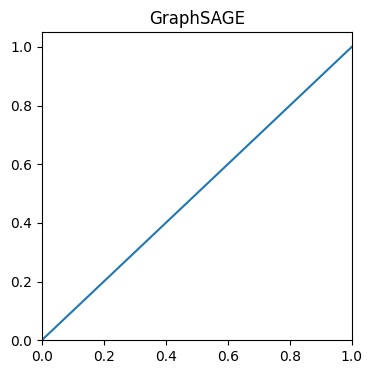

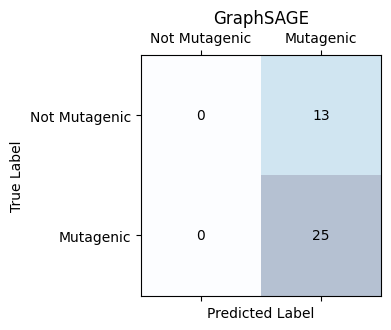

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.66      1.00      0.79        25

    accuracy                           0.66        38
   macro avg       0.33      0.50      0.40        38
weighted avg       0.43      0.66      0.52        38



(None, None, None)

In [ ]:
c_matplot(model, test_loader,1)

In [ ]:
# batch_size = 16
# train_loader, val_loader, test_loader = loader(batch_size = batch_size)
# trained_models_2 = []
# models = [GCN, GCN_m, GIN, GAT, GraphSAGE]
# testing_acc_2 = []
# training_acc_2 = []
# validation_acc_2 = []
# epoch_2 = []
# for model in models:
#   num_node_features = 9
#   model = model(dim_h = 32).to(device)
#   model, train_acc, val_acc, epochs = train(model, train_loader, 0.001, 100,2)
#   trained_models_2.append(model)
#   test_loss, test_acc = test(model, test_loader)
#   testing_acc_2.append(test_acc)
#   training_acc_2.append(train_acc)
#   validation_acc_2.append(val_acc)
#   epoch_2.append(epochs)
#   print(f'Test Loss: {test_loss : 2f} | Test Acc: {test_acc: 2f}%')

# dict = {'Train_acc': training_acc_2, 'Test_acc': testing_acc_2, 'Val_acc':validation_acc_2, 'Epoch': epoch_2}
# df = pd.DataFrame(dict)
# df.to_csv('/content/drive/MyDrive/graph_data/Metrics/exp2.csv')

### Better training Step implementation - modified - Training 2

In [ ]:
import torch
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Tuple, Dict
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import f1_score
import numpy as np

@dataclass
class TrainingConfig:
    lr: float = 0.001
    epochs: int = 100
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    criterion: nn.Module = nn.BCELoss()
    print_every: int = 5
    save_path: str = 'Over_Squashing_GNNs/models/Mutag_results/best_models'


class ModelTrainer:
    def __init__(self, model: nn.Module, config: TrainingConfig):
        self.model = model.to(config.device)
        self.config = config
        self.optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=0.01)

    @staticmethod
    def calculate_metrics(pred_y: torch.Tensor, y: torch.Tensor) -> dict:
        """Calculate multiple metrics for evaluation."""
        pred_binary = (pred_y.squeeze() >= 0.5).float()
        accuracy = (pred_binary == y).sum().item() / len(y)

        # Convert tensors to numpy for f1 calculation
        pred_np = pred_binary.cpu().numpy()
        y_np = y.cpu().numpy()
        f1 = f1_score(y_np, pred_np, average='binary')

        return {
            'accuracy': round(accuracy * 100, 2),
            'f1': round(f1, 3)
        }

    @torch.no_grad()
    def evaluate(self, loader: DataLoader) -> dict:
        """Evaluate model on given loader."""
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []

        for data in loader:
            data = data.to(self.config.device)
            out = self.model(data.x, data.edge_index, data.batch).view(-1)
            loss = self.config.criterion(out, data.y.float())

            total_loss += loss.item()
            all_preds.append(out)
            all_labels.append(data.y)

        # Concatenate all predictions and labels
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)

        # Calculate metrics
        metrics = self.calculate_metrics(all_preds, all_labels)
        metrics['loss'] = total_loss / len(loader)

        return metrics

    def train_epoch(self, train_loader: DataLoader) -> dict:
        """Train for one epoch."""
        self.model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for data in train_loader:
            data = data.to(self.config.device)
            self.optimizer.zero_grad()

            out = self.model(data.x, data.edge_index, data.batch).view(-1)
            loss = self.config.criterion(out, data.y.float())

            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            all_preds.append(out.detach())
            all_labels.append(data.y)

        # Concatenate all predictions and labels
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)

        # Calculate metrics
        metrics = self.calculate_metrics(all_preds, all_labels)
        metrics['loss'] = total_loss / len(train_loader)

        return metrics

    def train(self, train_loader: DataLoader, val_loader: DataLoader,
              test_loader: DataLoader, experiment_id: int) -> Tuple[dict, int]:
        """Full training loop with validation and testing."""
        train_metrics = []
        val_metrics = []
        best_val_acc = 0
        best_state = None

        for epoch in tqdm(range(self.config.epochs + 1)):
            # Train and evaluate
            train_results = self.train_epoch(train_loader)
            val_results = self.evaluate(val_loader)

            # Store metrics
            train_metrics.append(train_results)
            val_metrics.append(val_results)

            # Save best model
            if val_results['accuracy'] > best_val_acc:
                best_val_acc = val_results['accuracy']
                best_metrics = {
                    'train': train_results,
                    'val': val_results,
                    'epoch': epoch
                }
                best_state = self.model.state_dict()

            # Print progress
            if epoch % self.config.print_every == 0:
                print(f'Epoch {epoch:>3} | '
                      f'Train Loss: {train_results["loss"]:.3f} | '
                      f'Train Acc: {train_results["accuracy"]:>5.2f}% | '
                      f'Train F1: {train_results["f1"]:.3f} | '
                      f'Val Loss: {val_results["loss"]:.3f} | '
                      f'Val Acc: {val_results["accuracy"]:>5.2f}% | '
                      f'Val F1: {val_results["f1"]:.3f}')

        # Save and load best model
        model_name = type(self.model).__name__
        save_path = f'{self.config.save_path}/exp{experiment_id}_{model_name}.pth'
        torch.save(best_state, save_path)
        self.model.load_state_dict(best_state)

        # Evaluate on test set
        test_results = self.evaluate(test_loader)
        best_metrics['test'] = test_results

        # Plot training curves
        self._plot_training_curves(train_metrics, val_metrics, test_results)

        return best_metrics

    def _plot_training_curves(self, train_metrics: list, val_metrics: list, test_metrics: dict):
        """Plot comprehensive training curves including loss, accuracy, and F1 score."""
        plt.figure(figsize=(15, 5))

        # Plot loss
        plt.subplot(1, 3, 1)
        plt.plot([x['loss'] for x in train_metrics], 'b-', label='Train Loss')
        plt.plot([x['loss'] for x in val_metrics], 'r-', label='Val Loss')
        plt.axhline(y=test_metrics['loss'], color='g', linestyle='--',
                   label=f'Test Loss: {test_metrics["loss"]:.3f}')
        plt.title('Loss over epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 3, 2)
        plt.plot([x['accuracy'] for x in train_metrics], 'b-', label='Train Accuracy')
        plt.plot([x['accuracy'] for x in val_metrics], 'r-', label='Val Accuracy')
        plt.axhline(y=test_metrics['accuracy'], color='g', linestyle='--',
                   label=f'Test Acc: {test_metrics["accuracy"]:.2f}%')
        plt.title('Accuracy over epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        # Plot F1 score
        plt.subplot(1, 3, 3)
        plt.plot([x['f1'] for x in train_metrics], 'b-', label='Train F1')
        plt.plot([x['f1'] for x in val_metrics], 'r-', label='Val F1')
        plt.axhline(y=test_metrics['f1'], color='g', linestyle='--',
                   label=f'Test F1: {test_metrics["f1"]:.3f}')
        plt.title('F1 Score over epochs')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()

        plt.tight_layout()
        plt.show()

def print_results(best_metrics: Dict):
    """Print a formatted summary of the best model's performance."""
    print("\nBest Model Performance:")
    print(f"Epoch: {best_metrics['epoch']}")

    for split in ['train', 'val', 'test']:
        print(f"\n{split.capitalize()}:")
        print(f"Loss: {best_metrics[split]['loss']:.3f}")
        print(f"Accuracy: {best_metrics[split]['accuracy']:.2f}%")
        print(f"F1 Score: {best_metrics[split]['f1']:.3f}")




  1%|          | 1/101 [00:00<00:22,  4.36it/s]

Epoch   0 | Train Loss: 0.664 | Train Acc: 66.22% | Train F1: 0.793 | Val Loss: 0.660 | Val Acc: 67.11% | Val F1: 0.803


  6%|▌         | 6/101 [00:01<00:21,  4.40it/s]

Epoch   5 | Train Loss: 0.538 | Train Acc: 75.68% | Train F1: 0.816 | Val Loss: 0.590 | Val Acc: 68.42% | Val F1: 0.793


 11%|█         | 11/101 [00:02<00:20,  4.39it/s]

Epoch  10 | Train Loss: 0.505 | Train Acc: 77.03% | Train F1: 0.828 | Val Loss: 0.543 | Val Acc: 68.42% | Val F1: 0.769


 16%|█▌        | 16/101 [00:03<00:20,  4.14it/s]

Epoch  15 | Train Loss: 0.551 | Train Acc: 79.73% | Train F1: 0.845 | Val Loss: 0.557 | Val Acc: 71.05% | Val F1: 0.766


 21%|██        | 21/101 [00:04<00:17,  4.45it/s]

Epoch  20 | Train Loss: 0.556 | Train Acc: 79.73% | Train F1: 0.848 | Val Loss: 0.550 | Val Acc: 71.05% | Val F1: 0.766


 26%|██▌       | 26/101 [00:06<00:16,  4.44it/s]

Epoch  25 | Train Loss: 0.465 | Train Acc: 79.73% | Train F1: 0.848 | Val Loss: 0.539 | Val Acc: 69.74% | Val F1: 0.763


 31%|███       | 31/101 [00:07<00:15,  4.56it/s]

Epoch  30 | Train Loss: 0.476 | Train Acc: 79.73% | Train F1: 0.851 | Val Loss: 0.544 | Val Acc: 75.00% | Val F1: 0.800


 36%|███▌      | 36/101 [00:08<00:14,  4.46it/s]

Epoch  35 | Train Loss: 0.428 | Train Acc: 81.08% | Train F1: 0.863 | Val Loss: 0.545 | Val Acc: 76.32% | Val F1: 0.816


 41%|████      | 41/101 [00:09<00:13,  4.49it/s]

Epoch  40 | Train Loss: 0.436 | Train Acc: 81.08% | Train F1: 0.860 | Val Loss: 0.539 | Val Acc: 76.32% | Val F1: 0.820


 46%|████▌     | 46/101 [00:10<00:12,  4.44it/s]

Epoch  45 | Train Loss: 0.389 | Train Acc: 83.78% | Train F1: 0.880 | Val Loss: 0.550 | Val Acc: 76.32% | Val F1: 0.812


 50%|█████     | 51/101 [00:11<00:11,  4.51it/s]

Epoch  50 | Train Loss: 0.453 | Train Acc: 81.08% | Train F1: 0.863 | Val Loss: 0.537 | Val Acc: 75.00% | Val F1: 0.808


 55%|█████▌    | 56/101 [00:12<00:10,  4.34it/s]

Epoch  55 | Train Loss: 0.493 | Train Acc: 82.43% | Train F1: 0.874 | Val Loss: 0.536 | Val Acc: 76.32% | Val F1: 0.827


 60%|██████    | 61/101 [00:13<00:09,  4.41it/s]

Epoch  60 | Train Loss: 0.407 | Train Acc: 82.43% | Train F1: 0.874 | Val Loss: 0.540 | Val Acc: 76.32% | Val F1: 0.820


 65%|██████▌   | 66/101 [00:15<00:07,  4.44it/s]

Epoch  65 | Train Loss: 0.364 | Train Acc: 83.78% | Train F1: 0.882 | Val Loss: 0.540 | Val Acc: 77.63% | Val F1: 0.835


 70%|███████   | 71/101 [00:16<00:06,  4.50it/s]

Epoch  70 | Train Loss: 0.405 | Train Acc: 82.43% | Train F1: 0.874 | Val Loss: 0.539 | Val Acc: 76.32% | Val F1: 0.820


 75%|███████▌  | 76/101 [00:17<00:05,  4.46it/s]

Epoch  75 | Train Loss: 0.416 | Train Acc: 82.43% | Train F1: 0.874 | Val Loss: 0.537 | Val Acc: 77.63% | Val F1: 0.828


 80%|████████  | 81/101 [00:18<00:04,  4.42it/s]

Epoch  80 | Train Loss: 0.421 | Train Acc: 82.43% | Train F1: 0.874 | Val Loss: 0.533 | Val Acc: 75.00% | Val F1: 0.819


 85%|████████▌ | 86/101 [00:19<00:03,  4.16it/s]

Epoch  85 | Train Loss: 0.439 | Train Acc: 83.78% | Train F1: 0.882 | Val Loss: 0.546 | Val Acc: 77.63% | Val F1: 0.828


 90%|█████████ | 91/101 [00:20<00:02,  4.35it/s]

Epoch  90 | Train Loss: 0.374 | Train Acc: 83.78% | Train F1: 0.882 | Val Loss: 0.539 | Val Acc: 75.00% | Val F1: 0.816


 95%|█████████▌| 96/101 [00:21<00:01,  4.39it/s]

Epoch  95 | Train Loss: 0.420 | Train Acc: 81.08% | Train F1: 0.860 | Val Loss: 0.542 | Val Acc: 76.32% | Val F1: 0.824


100%|██████████| 101/101 [00:23<00:00,  4.37it/s]

Epoch 100 | Train Loss: 0.511 | Train Acc: 83.78% | Train F1: 0.882 | Val Loss: 0.548 | Val Acc: 80.26% | Val F1: 0.848


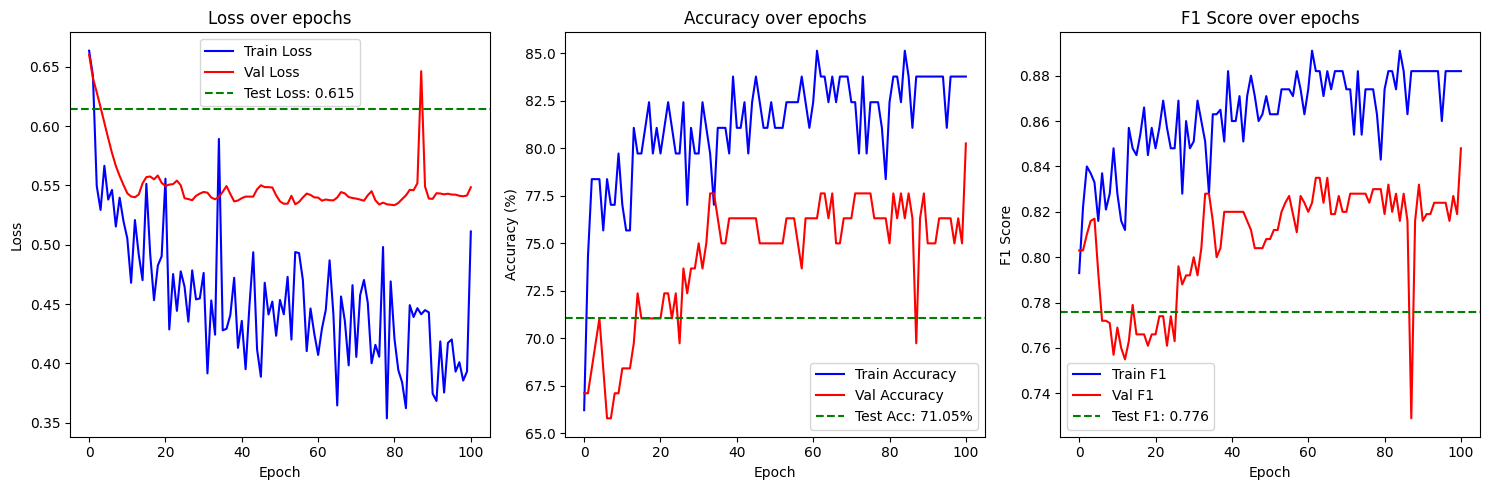


Best Model Performance:
Epoch: 100

Train:
Loss: 0.511
Accuracy: 83.78%
F1 Score: 0.882

Val:
Loss: 0.548
Accuracy: 80.26%
F1 Score: 0.848

Test:
Loss: 0.615
Accuracy: 71.05%
F1 Score: 0.776


In [ ]:
from torch_geometric.loader import DataLoader

batch_size = 32
train_loader, val_loader, test_loader = loader(mutag, batch_size = batch_size)
sage  = GraphSAGE_FA(dim_h = 128).to(device)
model = sage
# Configure training parameters
config = TrainingConfig(
    lr=0.001,
    epochs=100,
    print_every=5
)

# Initialize trainer
trainer = ModelTrainer(model, config)

# Train model
best_metrics = trainer.train(
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    experiment_id=2
)

test_loss, test_acc = test(model, test_loader)
print_results(best_metrics)



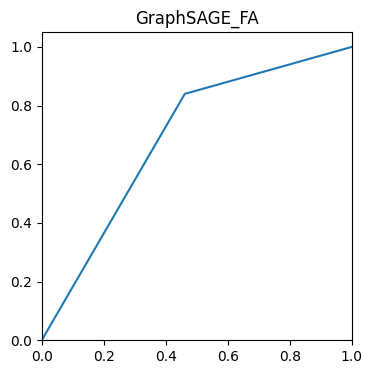

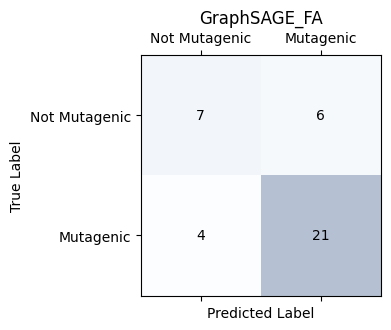

              precision    recall  f1-score   support

           0       0.64      0.54      0.58        13
           1       0.78      0.84      0.81        25

    accuracy                           0.74        38
   macro avg       0.71      0.69      0.70        38
weighted avg       0.73      0.74      0.73        38



(None, None, None)

In [ ]:
c_matplot(model, test_loader,1)

### Model Building with early stopping and LR scheduler - trial version
Just used to veriy or check. Not currently in use


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score, precision_recall_fscore_support
import wandb  # Optional for logging
from tqdm import tqdm

class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    predictions = []
    labels = []

    for data in loader:
        # Move data to device
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass
        out = model(data.x, data.edge_index, data.batch)
        out = out.squeeze()

        # Calculate loss
        loss = criterion(out, data.y.float())

        # Backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Store predictions and labels
        pred = (out >= 0.5).float()
        predictions.extend(pred.cpu().numpy())
        labels.extend(data.y.cpu().numpy())

        total_loss += loss.item() * data.num_graphs

    # Calculate metrics
    avg_loss = total_loss / len(loader.dataset)
    accuracy = np.mean(np.array(predictions) == np.array(labels))
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

    return avg_loss, accuracy, precision, recall, f1

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    labels = []

    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        out = out.squeeze()

        loss = criterion(out, data.y.float())
        total_loss += loss.item() * data.num_graphs

        pred = (out >= 0.5).float()
        predictions.extend(pred.cpu().numpy())
        labels.extend(data.y.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    accuracy = np.mean(np.array(predictions) == np.array(labels))
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

    return avg_loss, accuracy, precision, recall, f1

def train(model, train_loader, val_loader, config):
    """
    Main training function with improved features
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Initialize training components
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([config['pos_weight']]).to(device))
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['lr'],
        weight_decay=config['weight_decay']
    )
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=15,
        verbose=True
    )
    early_stopping = EarlyStopping(patience=15)

    # Training tracking
    best_val_f1 = 0
    best_model_state = None
    train_metrics = []
    val_metrics = []

    # Training loop
    for epoch in tqdm(range(config['epochs'])):
        # Training phase
        train_loss, train_acc, train_prec, train_rec, train_f1 = train_epoch(
            model, train_loader, criterion, optimizer, device
        )

        # Validation phase
        val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate(
            model, val_loader, criterion, device
        )

        # Learning rate scheduling
        scheduler.step(val_f1)

        # Early stopping check
        early_stopping(val_loss)

        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict().copy()

        # Store metrics
        train_metrics.append({
            'loss': train_loss,
            'accuracy': train_acc,
            'f1': train_f1,
            'precision': train_prec,
            'recall': train_rec
        })

        val_metrics.append({
            'loss': val_loss,
            'accuracy': val_acc,
            'f1': val_f1,
            'precision': val_prec,
            'recall': val_rec
        })

        # Optional: Log to wandb
        if config['use_wandb']:
            wandb.log({
                'train_loss': train_loss,
                'train_acc': train_acc,
                'train_f1': train_f1,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'val_f1': val_f1,
                'learning_rate': optimizer.param_groups[0]['lr']
            })

        # Print metrics
        if epoch % config['print_every'] == 0:
            print(f'Epoch {epoch:03d}:')
            print(f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}')

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # Load best model
    model.load_state_dict(best_model_state)
    return model, train_metrics, val_metrics

# Example configuration
config = {
    'lr': 0.0001,
    'weight_decay': 1e-3,
    'epochs': 100,
    'print_every': 5,
    'pos_weight': 1.0,  # Adjust based on class imbalance
    'use_wandb': False  # Set to True if using wandb
}

# Plotting function
def plot_training_metrics(train_metrics, val_metrics):
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot([x['loss'] for x in train_metrics], label='Train Loss')
    plt.plot([x['loss'] for x in val_metrics], label='Val Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot([x['accuracy'] for x in train_metrics], label='Train Accuracy')
    plt.plot([x['accuracy'] for x in val_metrics], label='Val Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot F1 score
    plt.subplot(1, 3, 3)
    plt.plot([x['f1'] for x in train_metrics], label='Train F1')
    plt.plot([x['f1'] for x in val_metrics], label='Val F1')
    plt.title('F1 Score over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  1%|          | 1/100 [00:00<00:23,  4.24it/s]

Epoch 000:
Train Loss: 0.6362, Acc: 0.7162, F1: 0.8000
Val Loss: 0.6353, Acc: 0.6711, F1: 0.8031


  6%|▌         | 6/100 [00:01<00:19,  4.70it/s]

Epoch 005:
Train Loss: 0.6260, Acc: 0.7973, F1: 0.8454
Val Loss: 0.6293, Acc: 0.6842, F1: 0.8095


 11%|█         | 11/100 [00:02<00:19,  4.46it/s]

Epoch 010:
Train Loss: 0.6198, Acc: 0.8108, F1: 0.8511
Val Loss: 0.6170, Acc: 0.6974, F1: 0.8034


 16%|█▌        | 16/100 [00:03<00:18,  4.54it/s]

Epoch 015:
Train Loss: 0.6151, Acc: 0.7838, F1: 0.8261
Val Loss: 0.6091, Acc: 0.7105, F1: 0.7963


 21%|██        | 21/100 [00:04<00:17,  4.62it/s]

Epoch 020:
Train Loss: 0.6142, Acc: 0.7703, F1: 0.8211
Val Loss: 0.6054, Acc: 0.6579, F1: 0.7500


 26%|██▌       | 26/100 [00:05<00:16,  4.61it/s]

Epoch 025:
Train Loss: 0.6119, Acc: 0.7703, F1: 0.8172
Val Loss: 0.6022, Acc: 0.6842, F1: 0.7600


 31%|███       | 31/100 [00:06<00:15,  4.50it/s]

Epoch 030:
Train Loss: 0.6093, Acc: 0.7703, F1: 0.8172
Val Loss: 0.6008, Acc: 0.6711, F1: 0.7475


 36%|███▌      | 36/100 [00:07<00:13,  4.60it/s]

Epoch 035:
Train Loss: 0.6074, Acc: 0.8108, F1: 0.8478
Val Loss: 0.6000, Acc: 0.7105, F1: 0.7708


 41%|████      | 41/100 [00:09<00:13,  4.49it/s]

Epoch 040:
Train Loss: 0.6076, Acc: 0.7838, F1: 0.8298
Val Loss: 0.5993, Acc: 0.7237, F1: 0.7789


 46%|████▌     | 46/100 [00:10<00:12,  4.36it/s]

Epoch 045:
Train Loss: 0.6054, Acc: 0.7432, F1: 0.7957
Val Loss: 0.5990, Acc: 0.7237, F1: 0.7789


 51%|█████     | 51/100 [00:11<00:11,  4.44it/s]

Epoch 050:
Train Loss: 0.6022, Acc: 0.7703, F1: 0.8211
Val Loss: 0.5987, Acc: 0.7368, F1: 0.7872


 52%|█████▏    | 52/100 [00:11<00:10,  4.39it/s]

Early stopping triggered


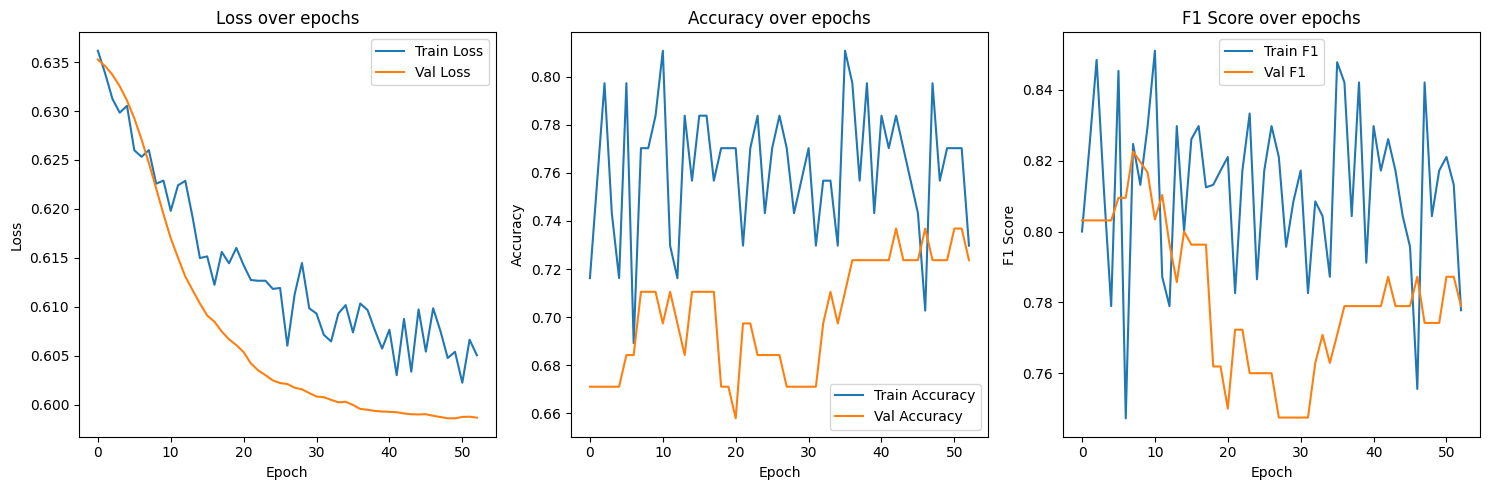

In [ ]:
batch_size = 32
train_loader, val_loader, test_loader = loader(mutag, batch_size = batch_size)
sage  = GraphSAGE_FA(dim_h = 128).to(device)
model = sage

# Train model
model, train_metrics, val_metrics = train(
    model,
    train_loader,
    val_loader,
    config
)

# Plot results
plot_training_metrics(train_metrics, val_metrics)
